In [1]:
import yfinance as yf
import os
import time
import requests
import random


import pandas as pd
import numpy as np
from matplotlib import pyplot as plt
from datetime import datetime, timedelta
import seaborn as sns
import statsmodels.graphics.tsaplots as sgt
import statsmodels.tsa.stattools as sts
from statsmodels.tsa.seasonal import seasonal_decompose
from scipy import stats
from distfit import distfit


from prophet import Prophet
from prophet.diagnostics import cross_validation, performance_metrics
from pmdarima import auto_arima

from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, ConfusionMatrixDisplay, confusion_matrix, roc_auc_score, roc_curve
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import GridSearchCV
from sklearn.preprocessing import MinMaxScaler

import lightgbm as lgb
import xgboost as xgb

from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dropout, Dense
from keras.optimizers import Adam
from sklearn.base import BaseEstimator

import tensorflow as tf
from tensorflow.keras.models import load_model

from sklearn.metrics import r2_score, mean_squared_error, mean_absolute_percentage_error


In [2]:
# Definir el ticker de Quálitas en la Bolsa Mexicana de Valores
# Configuración inicial
ticker_symbol = "Q.MX"
csv_filename = "qualitas_prices_04_04.csv"
start_date = "2025-02-01"

# Verificar si el CSV existe
if os.path.exists(csv_filename):
    print(f"Cargando datos locales desde {csv_filename}...")
    df_Q_all = pd.read_csv(csv_filename, index_col="Date", parse_dates=True)
else:
    print("Descargando datos desde Yahoo Finance...")
    
    # Configurar sesión con headers
    session = requests.Session()
    session.headers.update({
        'User-Agent': 'Mozilla/5.0 (Windows NT 10.0; Win64; x64) AppleWebKit/537.36 (KHTML, like Gecko) Chrome/120.0.0.0 Safari/537.36'
    })
    
    ticker = yf.Ticker(ticker_symbol, session=session)
    max_retries = 3
    retry_delay = 5
    success = False
    
    for attempt in range(max_retries):
        try:
            df_Q_all = ticker.history(start=start_date, end=None)
            df_Q_all.to_csv(csv_filename)
            print(f"Datos guardados en {csv_filename}.")
            success = True
            break
        except requests.exceptions.HTTPError as e:
            if e.response.status_code == 429:
                print(f"Intento {attempt+1}: Rate limit. Esperando {retry_delay} segundos...")
                time.sleep(retry_delay)
                retry_delay *= 2
            else:
                print(f"Error HTTP: {e}")
                break
        except Exception as e:
            print(f"Error inesperado: {str(e)}")
            break
    
    if not success:
        print("No se pudo descargar. Verifica el ticker o espera unas horas.")

# Mostrar datos
if 'df_Q_all' in locals():
    print("\nEjemplo de datos:")
    print(df_Q_all.head())
else:
    print("No hay datos disponibles.")

Cargando datos locales desde qualitas_prices_04_04.csv...

Ejemplo de datos:
                                Open       High        Low      Close  Volume  \
Date                                                                            
2015-07-17 00:00:00-05:00  21.103882  21.118946  20.712232  20.953247   34299   
2015-07-20 00:00:00-05:00  20.719763  21.156603  20.712232  20.915588   79808   
2015-07-21 00:00:00-05:00  20.938181  20.938181  20.719762  20.870396   59068   
2015-07-22 00:00:00-05:00  20.877930  21.043628  20.712232  20.953247  378294   
2015-07-23 00:00:00-05:00  20.877927  21.005967  20.712230  20.923119  145393   

                           Dividends  Stock Splits  
Date                                                
2015-07-17 00:00:00-05:00        0.0           0.2  
2015-07-20 00:00:00-05:00        0.0           0.0  
2015-07-21 00:00:00-05:00        0.0           0.0  
2015-07-22 00:00:00-05:00        0.0           0.0  
2015-07-23 00:00:00-05:00        0.0 

In [3]:
display(df_Q_all.tail())

,Open,High,Low,Close,Volume,Dividends,Stock Splits
Date,,,,,,,
2025-04-04 00:00:00-06:00,182.399994,186.839996,173.229996,174.000000,991647,0.0,0.0
2025-04-07 00:00:00-06:00,172.190002,177.550003,161.880005,174.000000,404321,0.0,0.0
2025-04-08 00:00:00-06:00,176.970001,178.080002,174.339996,175.699997,979444,0.0,0.0
2025-04-09 00:00:00-06:00,176.000000,179.949997,174.630005,179.940002,891125,0.0,0.0
2025-04-10 00:00:00-06:00,177.710007,181.600006,177.710007,179.250000,422544,0.0,0.0


In [4]:
df_Q_close= df_Q_all["Close"].to_frame()
# Cambiar la columna "Close" a "Q.MX"
df_Q_close = df_Q_close.rename(columns={"Close": "Q close"})

# Paso 1: Convertir el índice a datetime con utc=True para manejar tz-aware
df_Q_close.index = pd.to_datetime(df_Q_close.index, utc=True)

# Paso 2: Quitar huso horario
df_Q_close.index = df_Q_close.index.tz_localize(None)

# Paso 3: Normalizar fechas (eliminar horas, minutos y segundos)
df_Q_close.index = df_Q_close.index.normalize()  # <--- ¡Clave aquí!

# Paso 4: Establecer frecuencia a días hábiles (usa "B" en mayúscula)
df_Q_close = df_Q_close.asfreq("B")

df_Q_close = df_Q_close.fillna(method= "bfill")

# Verificar
display(df_Q_close.head())

print(df_Q_close.info())

,Q close
Date,
2015-07-17,20.953247
2015-07-20,20.915588
2015-07-21,20.870396
2015-07-22,20.953247
2015-07-23,20.923119


<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 2540 entries, 2015-07-17 to 2025-04-10
Freq: B
Data columns (total 1 columns):
 #   Column   Non-Null Count  Dtype  
---  ------   --------------  -----  
 0   Q close  2540 non-null   float64
dtypes: float64(1)
memory usage: 39.7 KB
None


## Data de diferenciación con logaritmo

Uso en finanzas cuantitativas Estándar de facto (log-returns)

🎯 Recomendación:
Usa rendimientos logarítmicos, sobre todo si:

* Te interesa un modelo más robusto y "financieramente coherente"

* Planeas hacer predicción multi-step (porque puedes sumar log-retornos)

* Quieres evitar que el modelo aprenda solo los niveles de precio en vez de los movimientos relativos


In [5]:
df_transform =pd.DataFrame()
df_transform['log_return']= np.log(df_Q_close['Q close'] / df_Q_close['Q close'].shift(1)).dropna()
display(df_transform.head())
print(df_transform.info())

,log_return
Date,
2015-07-20,-0.001799
2015-07-21,-0.002163
2015-07-22,0.003962
2015-07-23,-0.001439
2015-07-24,-0.002162


<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 2539 entries, 2015-07-20 to 2025-04-10
Freq: B
Data columns (total 1 columns):
 #   Column      Non-Null Count  Dtype  
---  ------      --------------  -----  
 0   log_return  2539 non-null   float64
dtypes: float64(1)
memory usage: 39.7 KB
None


### División de data en train y test. Escalar datos

In [6]:
display(df_Q_close)

,Q close
Date,
2015-07-17,20.953247
2015-07-20,20.915588
2015-07-21,20.870396
2015-07-22,20.953247
2015-07-23,20.923119
...,...
2025-04-04,174.000000
2025-04-07,174.000000
2025-04-08,175.699997


In [7]:
display(df_transform)

,log_return
Date,
2015-07-20,-0.001799
2015-07-21,-0.002163
2015-07-22,0.003962
2015-07-23,-0.001439
2015-07-24,-0.002162
...,...
2025-04-04,-0.050431
2025-04-07,0.000000
2025-04-08,0.009723


In [8]:
size = size = int(len(df_Q_close) * 0.85)
trans_train = df_transform.iloc[:size]
trans_test = df_transform.iloc[size:]

df_Q_close_train= df_Q_close.iloc[:size]
df_Q_close_test = df_Q_close.iloc[size:]
#--------------------------------------------------Escalar Precios
scaler = MinMaxScaler()
scaler.fit(df_Q_close_train)

scaled_precios_train= scaler.transform(df_Q_close_train)
scaled_precios_test = scaler.transform(df_Q_close_test)

#------------------Escalar log-returns
scaler_2= MinMaxScaler()
scaler_2.fit(trans_train)

scaled_trans_train = scaler_2.transform(trans_train)
scaled_trans_test = scaler_2.transform(trans_test)


display(trans_test)
display(df_Q_close_test)

,log_return
Date,
2023-10-27,0.021023
2023-10-30,0.006396
2023-10-31,0.000201
2023-11-01,-0.000873
2023-11-02,-0.043091
...,...
2025-04-04,-0.050431
2025-04-07,0.000000
2025-04-08,0.009723


,Q close
Date,
2023-10-26,139.389679
2023-10-27,142.351120
2023-10-30,143.264542
2023-10-31,143.293396
2023-11-01,143.168396
...,...
2025-04-04,174.000000
2025-04-07,174.000000
2025-04-08,175.699997


# Elección del modelo

In [9]:
# Fijar la semilla para reproducibilidad
seed = 42
random.seed(seed)                      # Python
np.random.seed(seed)                   # NumPy
tf.random.set_seed(seed)               # TensorFlow

# Asegurar reproducibilidad en TensorFlow
os.environ['PYTHONHASHSEED'] = str(seed)

### Estructura del código

create_sequences(): Función para crear las secuencias con la ventana de entrada (lookback).

build_lstm_model(): Tu modelo LSTM ya validado.

evaluate_model(): Calcula y visualiza las métricas (R², MSE, RMSE, MAPE).

train_and_evaluate_lstm(): Función principal que entrena y evalúa el modelo para diferentes horizontes de predicción.

In [10]:
# Función para crear secuencias (asegura que los datos tengan forma (n,1))
def create_sequences(data, lookback, horizon):
    data = np.asarray(data)
    if data.ndim == 1:
        data = data.reshape(-1, 1)
    
    X, y = [], []
    for i in range(lookback, len(data) - horizon + 1):
        X.append(data[i - lookback:i, 0])
        y.append(data[i + horizon - 1, 0])
    X = np.array(X).reshape(-1, lookback, 1)
    y = np.array(y)
    return X, y

# Función para construir el modelo LSTM
def build_lstm_model(X_train):
    model = Sequential()
    model.add(LSTM(100, activation='relu', input_shape=(X_train.shape[1], X_train.shape[2])))
    model.add(Dropout(0.2))
    model.add(Dense(1))
    model.compile(optimizer='adam', loss='mse')
    return model

# Función para evaluar y graficar
def evaluate_model(y_true, y_pred, model_name, plot=True):
    r2 = r2_score(y_true, y_pred)
    mse = mean_squared_error(y_true, y_pred)
    rmse = mean_squared_error(y_true, y_pred, squared=False)
    mape = mean_absolute_percentage_error(y_true, y_pred)
    
    metrics = {'Model': model_name, 'R2': r2, 'MSE': mse, 'RMSE': rmse, 'MAPE': mape}
    print(f"Evaluación de {model_name}:")
    print(f"R²: {r2:.4f}, MSE: {mse:.4f}, RMSE: {rmse:.4f}, MAPE: {mape:.4f}")
    
    if plot:
        plt.figure(figsize=(10, 5))
        plt.plot(y_true, label='Real')
        plt.plot(y_pred, label='Predicción')
        plt.title(f'{model_name} - Real vs Predicción')
        plt.legend()
        plt.show()
    return metrics

# Función para reconstruir precios a partir de log-retornos (horizonte 1)
def logret_to_price(y_logret_pred, base_prices):
    """
    y_logret_pred: vector de predicciones de log-retorno (en escala real, desescalado)
    base_prices: vector de precios reales correspondientes al día anterior a la predicción.
    """
    return base_prices * np.exp(y_logret_pred)

# Función principal para entrenar y evaluar el modelo
def train_and_evaluate_lstm(data, lookback, horizon, model_name, transform_type="raw", base_series=None, 
                            epochs=10, batch_size=32, plot=True, return_model=False):
    """
    Parámetros:
    - data: DataFrame o array de la serie a modelar.
    - lookback: tamaño de la ventana (por ejemplo, 20)
    - horizon: horizonte de predicción (se asume 1 para reconstrucción)
    - model_name: etiqueta para identificar el modelo.
    - transform_type: "raw", "log", o "log_scaled"
         "raw": se escalan los precios.
         "log": se usan log-retornos sin escalar.
         "log_scaled": se usan log-retornos escalados.
    - base_series: (necesario para "log" o "log_scaled") serie de precios reales (sin transformar) para reconstrucción.
    - epochs, batch_size, plot: parámetros para entrenamiento y visualización.
    - return_model: si es True, se retorna además el modelo entrenado.
    
    Retorna:
    - Diccionario con las métricas, y opcionalmente el modelo entrenado.
    """
    # 1. Evitar leakage: dividir la data antes de escalar
    split_point = int(len(data) * 0.85)
    data_train = data[:split_point]
    data_test  = data[split_point:]
    
    # 2. Escalado (si corresponde)
    if transform_type in ["raw", "log_scaled"]:
        scaler = MinMaxScaler()
        scaler.fit(data_train)
        scaled_train = scaler.transform(data_train)
        scaled_test  = scaler.transform(data_test)
    else:
        scaled_train = np.asarray(data_train)
        scaled_test  = np.asarray(data_test)
    
    # 3. Crear secuencias
    X_train, y_train = create_sequences(scaled_train, lookback, horizon)
    X_test, y_test   = create_sequences(scaled_test, lookback, horizon)
    
    # 4. Construir y entrenar el modelo
    model = build_lstm_model(X_train)
    model.fit(X_train, y_train, epochs=epochs, batch_size=batch_size, verbose=0)
    
    # 5. Predecir
    y_pred = model.predict(X_test, batch_size=batch_size)
    
    # 6. Inversión de transformaciones para evaluación en escala real
    if transform_type == "raw":
        y_pred = scaler.inverse_transform(y_pred.reshape(-1, 1)).flatten()
        y_test = scaler.inverse_transform(y_test.reshape(-1, 1)).flatten()
    elif transform_type in ["log", "log_scaled"]:
        if transform_type == "log_scaled":
            y_pred = scaler.inverse_transform(y_pred.reshape(-1, 1)).flatten()
            y_test = scaler.inverse_transform(y_test.reshape(-1, 1)).flatten()
        # Asegurarse de que las predicciones sean 1D
        y_pred = y_pred.flatten()
        y_test = y_test.flatten()
        # Extraer base de precios para el test: usar desde el índice split_point + lookback
        base_series = np.asarray(base_series)
        base_prices_test = base_series[split_point + lookback: len(base_series)]
        if len(base_prices_test) != len(y_pred):
            raise ValueError("El número de base prices no coincide con las predicciones.")
        y_pred = logret_to_price(y_pred, base_prices_test)
        y_test = logret_to_price(y_test, base_prices_test)
    
    # 7. Evaluar y graficar
    metrics = evaluate_model(y_test, y_pred, model_name, plot=plot)
    
    if return_model:
        return metrics, model
    else:
        return metrics



12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
Evaluación de Precio_t+1:
R²: 0.6134, MSE: 134.2139, RMSE: 11.5851, MAPE: 0.0518


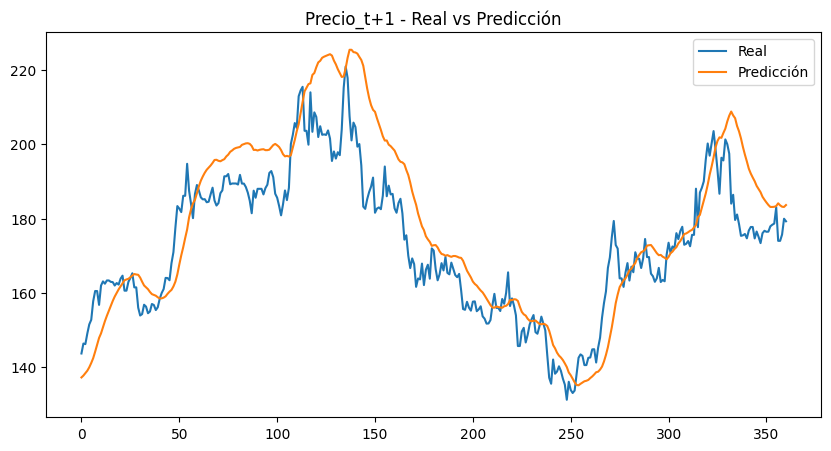

12/12 ━━━━━━━━━━━━━━━━━━━━ 1s 32ms/step
Evaluación de LogRet_scaled_t+1:
R²: 0.9600, MSE: 14.9468, RMSE: 3.8661, MAPE: 0.0164


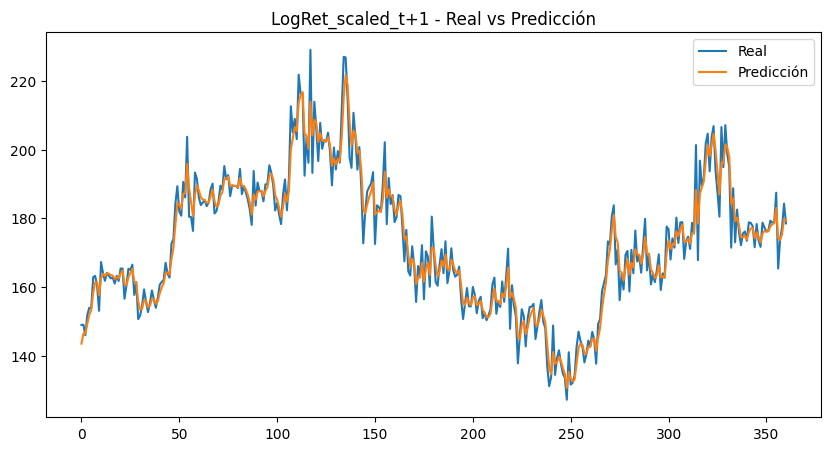

12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
Evaluación de LogRet_t+1:
R²: 0.9612, MSE: 14.5331, RMSE: 3.8122, MAPE: 0.0161


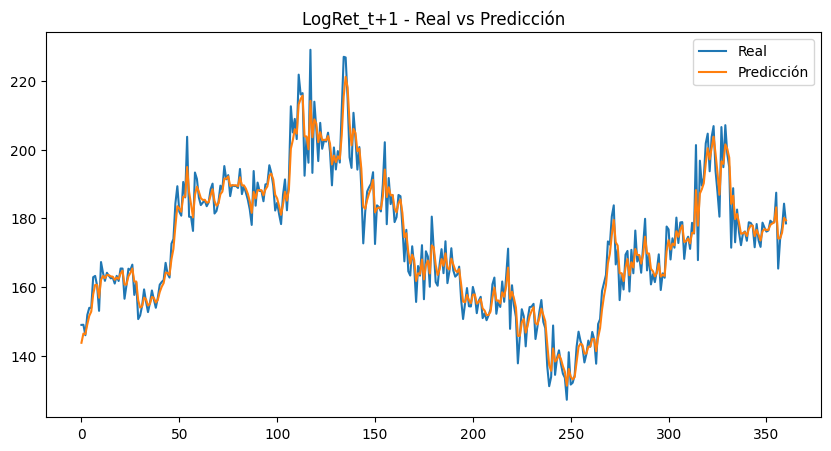

               Model        R2         MSE       RMSE      MAPE
0         Precio_t+1  0.613393  134.213887  11.585072  0.051754
1  LogRet_scaled_t+1  0.960047   14.946819   3.866112  0.016399
2         LogRet_t+1  0.961153   14.533111   3.812232  0.016130


In [11]:
# ------------------------------
# Ejemplos de uso:
#
# Suponiendo que:
# - df_Q_close es un DataFrame con la columna "Q close" de precios.
# - df_transform es un DataFrame con la columna "log_return", ya calculada.
#
# Para el modelo de precios (raw):
scaled_precios = df_Q_close["Q close"].iloc[1:].values.reshape(-1, 1)  # asegúrate de pasar DataFrame de 1 columna
metrics_precio = train_and_evaluate_lstm(scaled_precios, lookback=20, horizon=1, 
                                           model_name="Precio_t+1", transform_type="raw",
                                           epochs=10, batch_size=32, plot=True)

# Para log-retornos escalados:
# Se asume que df_transform tiene la columna "log_return" y base_series es df_Q_close["Q close"]
metrics_log_scaled = train_and_evaluate_lstm(df_transform[['log_return']], lookback=20, horizon=1,
                                               model_name="LogRet_scaled_t+1", transform_type="log_scaled",
                                               base_series=df_Q_close["Q close"].iloc[1:].values,  # Ajustamos la base ya que difieren por una observación dada la construcción
                                               epochs=10, batch_size=32, plot=True)

# Para log-retornos sin escalar:
metrics_log = train_and_evaluate_lstm(df_transform[['log_return']], lookback=20, horizon=1,
                                        model_name="LogRet_t+1", transform_type="log",
                                        base_series=df_Q_close["Q close"].iloc[1:].values,
                                        epochs=10, batch_size=32, plot=True)

# Puedes guardar todas las métricas en un DataFrame para comparar:
results = [metrics_precio, metrics_log_scaled, metrics_log]
df_results = pd.DataFrame(results)
print(df_results)


In [12]:
# Entrenar el modelo y obtenerlo junto con sus métricas
metrics_log, modelo_log = train_and_evaluate_lstm(
    df_transform[['log_return']], 
    lookback=20, 
    horizon=1,
    model_name="LogRet_t+1", 
    transform_type="log",
    base_series=df_Q_close["Q close"].iloc[1:].values,
    epochs=10, 
    batch_size=32, 
    plot=False, 
    return_model=True
)
# Dado que nuestro modelo Para log-retornos sin escalar, no usamos escalar los datos no se guarda el escalador pero debe estar presente en otros ejemplos para también guardarlo.
# Guardar el modelo en formato .h5
modelo_log.save("modelo_logret_t1.h5")

12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step


[distfit] >WARNING> You are saving your model as an HDF5 file via `model.save()` or `keras.saving.save_model(model)`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')` or `keras.saving.save_model(model, 'my_model.keras')`. 


Evaluación de LogRet_t+1:
R²: 0.9612, MSE: 14.5328, RMSE: 3.8122, MAPE: 0.0161


In [13]:
def limpiar_yfinance(df, col_cierre="Close", freq="B"):
    # Limpiar nombres de columnas (remover espacios en blanco)
    df.columns = df.columns.str.strip()
    
    # Si 'Date' está en las columnas, se utiliza como fecha; de lo contrario, se asume que el índice ya es la fecha.
    if "Date" in df.columns:
        df["Date"] = pd.to_datetime(df["Date"], utc=True)
        df.set_index("Date", inplace=True)
    else:
        # Convertir el índice a datetime si no lo es
        df.index = pd.to_datetime(df.index, utc=True)
    
    # Quitar zona horaria y normalizar las fechas (elimina horas, minutos, segundos)
    df.index = df.index.tz_localize(None)
    df.index = df.index.normalize()
    
    # Renombrar la columna de cierre
    df = df.rename(columns={col_cierre: "Q close"})
    
    # Establecer la frecuencia a días hábiles
    df = df.asfreq(freq)
    
    # Rellenar huecos (si existiesen) usando el valor del día anterior
    df = df.fillna(method="bfill")
    
    return df

In [14]:
def predict_next_day_price(model, historical_df, lookback=20, col_close="Q close"):
    """
    Predice el precio de cierre del día siguiente a partir de datos históricos.
    
    Parámetros:
      - model: Modelo Keras previamente entrenado para predecir log‑retornos t+1.
      - historical_df: DataFrame original proveniente de yfinance (con columna "Date" y "Close").
      - lookback: Número de días que se usan en la secuencia (por defecto 20).
      - col_close: Nombre de la columna de precios de cierre en el DataFrame original (por defecto "Q close", 
                   luego de la limpieza se renombra).
    
    Retorna:
      - pred_price: Precio predicho para el día siguiente.
    """
    # 1. Limpiar y organizar el DataFrame
    df = limpiar_yfinance(historical_df, col_cierre=col_close)
    
    # 2. Calcular los log‑retornos
    df["log_return"] = np.log(df["Q close"] / df["Q close"].shift(1))
    df = df.dropna()  # Elimina el primer NaN, lo que implica que df tendrá una fila menos
    
    # 3. Extraer la secuencia de los últimos "lookback" log‑retornos
    # La secuencia debe tener forma (1, lookback, 1)
    logret_sequence = df["log_return"].values[-lookback:]
    input_sequence = logret_sequence.reshape(1, lookback, 1)
    
    # 4. Realizar la predicción del log‑retorno para t+1
    pred_log_ret = model.predict(input_sequence, batch_size=1)[0, 0]
    
    # 5. Obtener el último precio real conocido
    last_price = df["Q close"].values[-1]
    
    # 6. Reconstruir el precio de t+1 usando la fórmula: P_pred = last_price * exp(pred_log_ret)
    pred_price = last_price * np.exp(pred_log_ret)
    
    return pred_price


In [15]:
#ejecición del pipeline de limpieza de yfinance y predicción.

# 1. Cargar el modelo guardado
custom_objects = {'mse': tf.keras.losses.mse}
modelo_cargado = load_model("modelo_logret_t1.h5", custom_objects=custom_objects)

# 2. Cargar los datos históricos desde el CSV
historical_df = pd.read_csv("qualitas_prices_04_04.csv")

# 3. Realizar la predicción del precio para el día siguiente
precio_predicho = predict_next_day_price(modelo_cargado, historical_df, lookback=20, col_close="Close")
print(f"El precio predicho para el día siguiente es: {precio_predicho:.2f}")

# 4. (Opcional) Visualizar la predicción en un gráfico
# Primero, limpiar el DataFrame para graficar
df_limpio = limpiar_yfinance(historical_df, col_cierre="Close")
df_limpio = df_limpio.reset_index().rename(columns={"Date": "Fecha"})

display(df_limpio.columns)

[distfit] >WARNING> Compiled the loaded model, but the compiled metrics have yet to be built. `model.compile_metrics` will be empty until you train or evaluate the model.


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 157ms/step
El precio predicho para el día siguiente es: 179.45


Index(['Fecha', 'Open', 'High', 'Low', 'Q close', 'Volume', 'Dividends',
       'Stock Splits'],
      dtype='object')

[distfit] >WARNING> Compiled the loaded model, but the compiled metrics have yet to be built. `model.compile_metrics` will be empty until you train or evaluate the model.


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 151ms/step
El precio predicho para el día siguiente es: 179.45


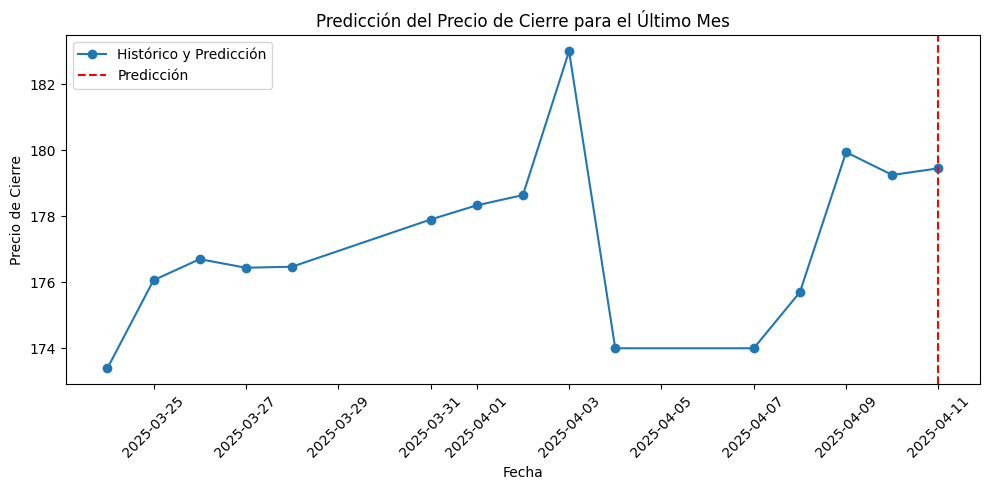

In [16]:
#ejecición del pipeline de limpieza de yfinance y predicción.

# 1. Cargar el modelo guardado
custom_objects = {'mse': tf.keras.losses.mse}
modelo_cargado = load_model("modelo_logret_t1.h5", custom_objects=custom_objects)

# 2. Cargar los datos históricos desde el CSV
historical_df = pd.read_csv("qualitas_prices_04_04.csv")

# 3. Realizar la predicción del precio para el día siguiente
precio_predicho = predict_next_day_price(modelo_cargado, historical_df, lookback=20, col_close="Close")
print(f"El precio predicho para el día siguiente es: {precio_predicho:.2f}")

# 4. (Opcional) Visualizar la predicción en un gráfico
# Primero, limpiar el DataFrame para graficar
df_limpio = limpiar_yfinance(historical_df, col_cierre="Close")
df_limpio = df_limpio.reset_index().rename(columns={"Date": "Fecha"})

# Agregar la predicción como una nueva fila (se asume que el siguiente día es el próximo día hábil)
ultimo_dia = df_limpio["Fecha"].iloc[-1]
# Para obtener el siguiente día hábil, sumamos 1 día y usamos pd.offsets.BDay
siguiente_dia = ultimo_dia + pd.offsets.BDay(1)
df_pred = pd.DataFrame({"Fecha": [siguiente_dia], "Q close": [precio_predicho]})
df_total = pd.concat([df_limpio, df_pred], ignore_index=True)

# Obtener la fecha del último día en el DataFrame
ultimo_dia = df_total["Fecha"].max()

# Calcular el primer día del último mes
primer_dia_mes = ultimo_dia - timedelta(days=20)

# Filtrar el DataFrame para incluir solo el último mes
df_ultimo_mes = df_total[df_total["Fecha"] >= primer_dia_mes]

# Graficar los datos del último mes
plt.figure(figsize=(10, 5))
plt.plot(df_ultimo_mes["Fecha"], df_ultimo_mes["Q close"], marker="o", label="Histórico y Predicción")
plt.axvline(x=siguiente_dia, color="r", linestyle="--", label="Predicción")
plt.title("Predicción del Precio de Cierre para el Último Mes")
plt.xlabel("Fecha")
plt.ylabel("Precio de Cierre")
plt.legend()
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()
